* **Компания:** ООО «Газпромнефть-Снабжение»
* **Автор нотбука:** Петросян Акоб
* **Номер:** +79309878934
* **Адрес:** МФТИ, г. Долгопрудный, Московская область
* **Обратная связь:** akob.petrosyan@phystech.edu, [vk.com/jacpetro](vk.com/jacpetro), [https://t.me/jacpetro](https://t.me/jacpetro).

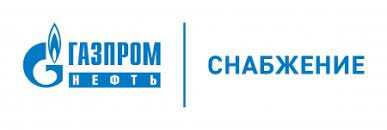

In [101]:
# Standard modules
import warnings
from typing import Union, Tuple

# Third-party modules
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import xgboost as xgb
from xgboost import plot_importance
from sklearn.base import RegressorMixin
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [3]:
df = pd.read_parquet(r"Копия zra_4_150_40_ts.parquet")

## EDA

In [4]:
df

,sintez_group,posting_date,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,stock_sum
0,ЗРА_4_150_40,2017-01-01,0,0.0,0,0.0,507.0
1,ЗРА_4_150_40,2017-01-02,0,0.0,0,0.0,507.0
2,ЗРА_4_150_40,2017-01-03,0,0.0,0,0.0,507.0
3,ЗРА_4_150_40,2017-01-04,0,0.0,0,0.0,505.0
4,ЗРА_4_150_40,2017-01-05,0,0.0,0,0.0,505.0
...,...,...,...,...,...,...,...
2029,ЗРА_4_150_40,2022-07-23,0,0.0,0,0.0,485.0
2030,ЗРА_4_150_40,2022-07-24,0,0.0,0,0.0,485.0
2031,ЗРА_4_150_40,2022-07-25,0,0.0,0,0.0,485.0
2032,ЗРА_4_150_40,2022-07-26,0,0.0,0,0.0,485.0


In [5]:
df.describe()

,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,stock_sum
count,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000
mean,0.333825,1.226647,0.939036,1.372173,561.427729
std,1.231720,5.367577,2.319154,3.530157,103.471147
min,0.000000,0.000000,0.000000,0.000000,371.000000
25%,0.000000,0.000000,0.000000,0.000000,485.000000
50%,0.000000,0.000000,0.000000,0.000000,553.000000
75%,0.000000,0.000000,1.000000,1.000000,619.000000
max,18.000000,95.000000,30.000000,45.000000,783.000000


In [6]:
unique_info = pd.Series(index=df.columns)
for column in df.columns:
    unique_info[column] = len(df[column].unique())
unique_info

<ipython-input-6-f0b57e9d4fa4>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  unique_info = pd.Series(index=df.columns)


sintez_group             1.0
posting_date          2034.0
inc_bmu_fact_count      15.0
inc_bmu_sum             43.0
out_bmu_fact_count      21.0
out_bmu_sum             32.0
stock_sum              335.0
dtype: float64

In [7]:
(df==0).sum(axis=0)

sintez_group             0
posting_date             0
inc_bmu_fact_count    1774
inc_bmu_sum           1774
out_bmu_fact_count    1368
out_bmu_sum           1368
stock_sum                0
dtype: int64

In [8]:
df.isna().sum()

sintez_group          0
posting_date          0
inc_bmu_fact_count    0
inc_bmu_sum           0
out_bmu_fact_count    0
out_bmu_sum           0
stock_sum             0
dtype: int64

In [9]:
df = df.set_index("posting_date")
df.index = pd.to_datetime(df.index)
df = df[['inc_bmu_fact_count', 'inc_bmu_sum',
       'out_bmu_fact_count', 'out_bmu_sum', 'stock_sum']]

In [10]:
(df["out_bmu_fact_count"] == df["out_bmu_sum"]).sum()

1718

In [11]:
df

,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,stock_sum
posting_date,,,,,
2017-01-01,0,0.0,0,0.0,507.0
2017-01-02,0,0.0,0,0.0,507.0
2017-01-03,0,0.0,0,0.0,507.0
2017-01-04,0,0.0,0,0.0,505.0
2017-01-05,0,0.0,0,0.0,505.0
...,...,...,...,...,...
2022-07-23,0,0.0,0,0.0,485.0
2022-07-24,0,0.0,0,0.0,485.0
2022-07-25,0,0.0,0,0.0,485.0


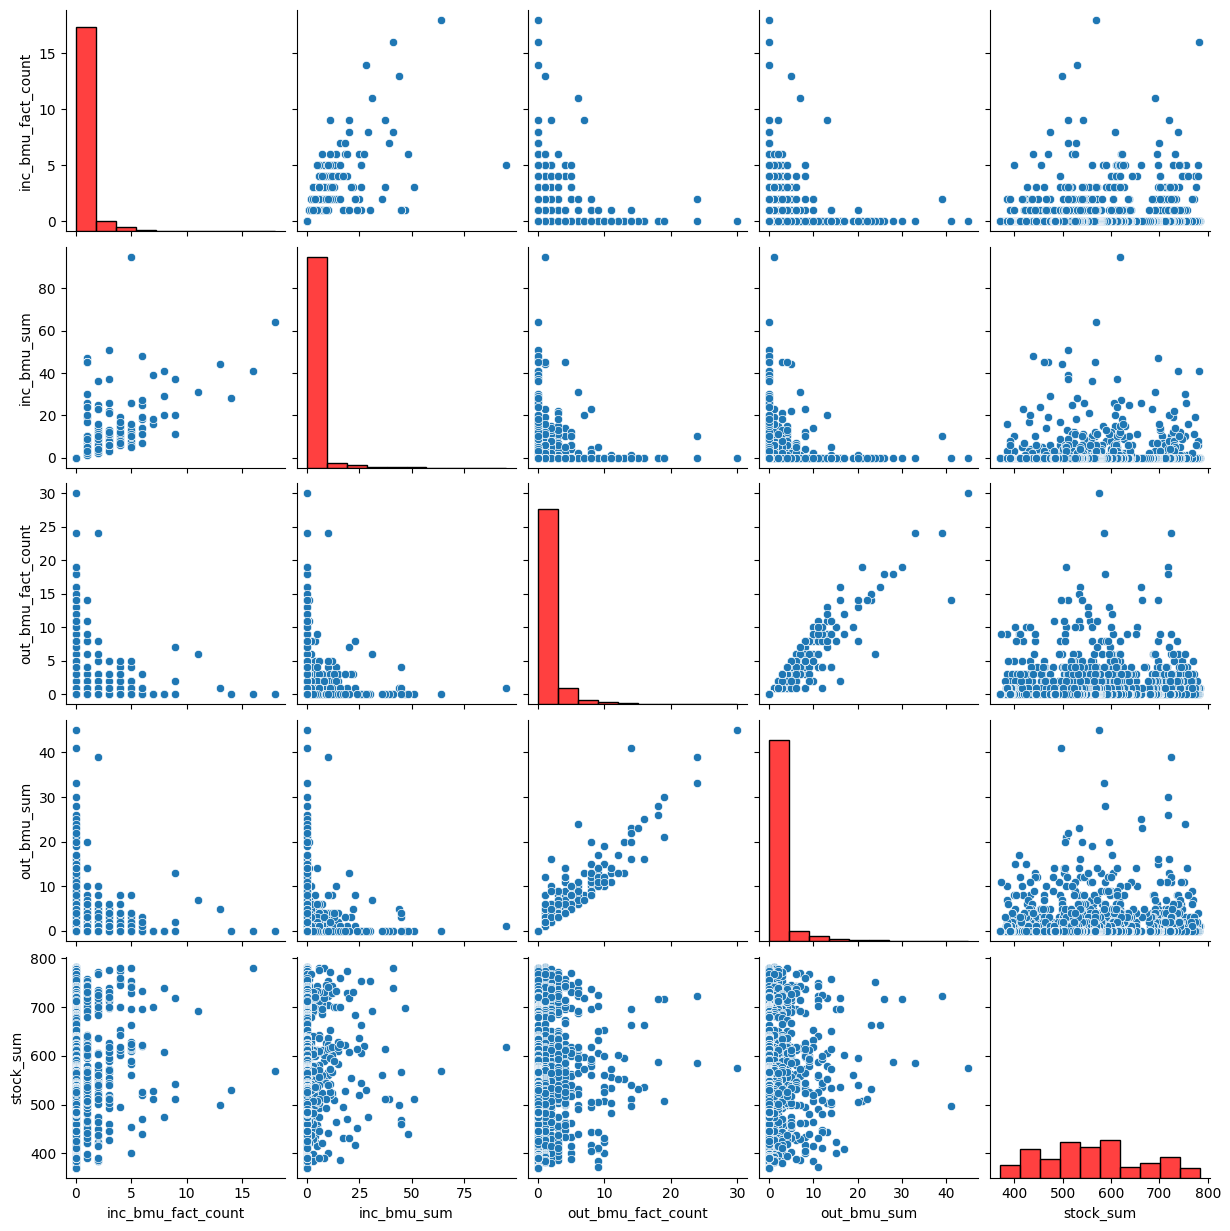

In [12]:
sns.pairplot(df, diag_kws={'color':'red', 'bins':10})

<ipython-input-13-8f7ec44cfdd1>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=ax, bins=20)


array([[<Axes: title={'center': 'inc_bmu_fact_count'}>,
        <Axes: title={'center': 'inc_bmu_sum'}>],
       [<Axes: title={'center': 'out_bmu_fact_count'}>,
        <Axes: title={'center': 'out_bmu_sum'}>],
       [<Axes: title={'center': 'stock_sum'}>, <Axes: >]], dtype=object)

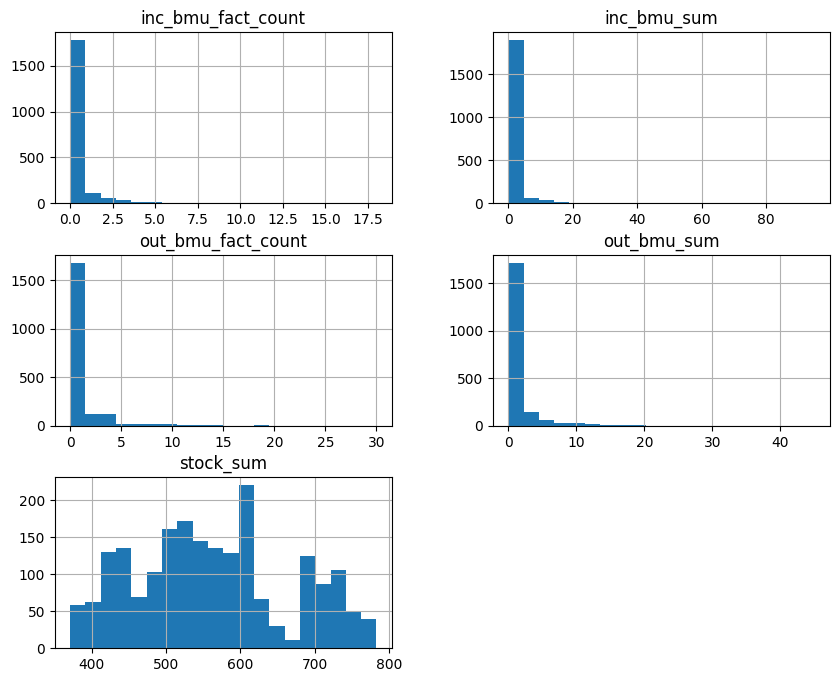

In [13]:
fig = plt.figure(figsize = (10,8))
ax = fig.gca()
df.hist(ax=ax, bins=20)

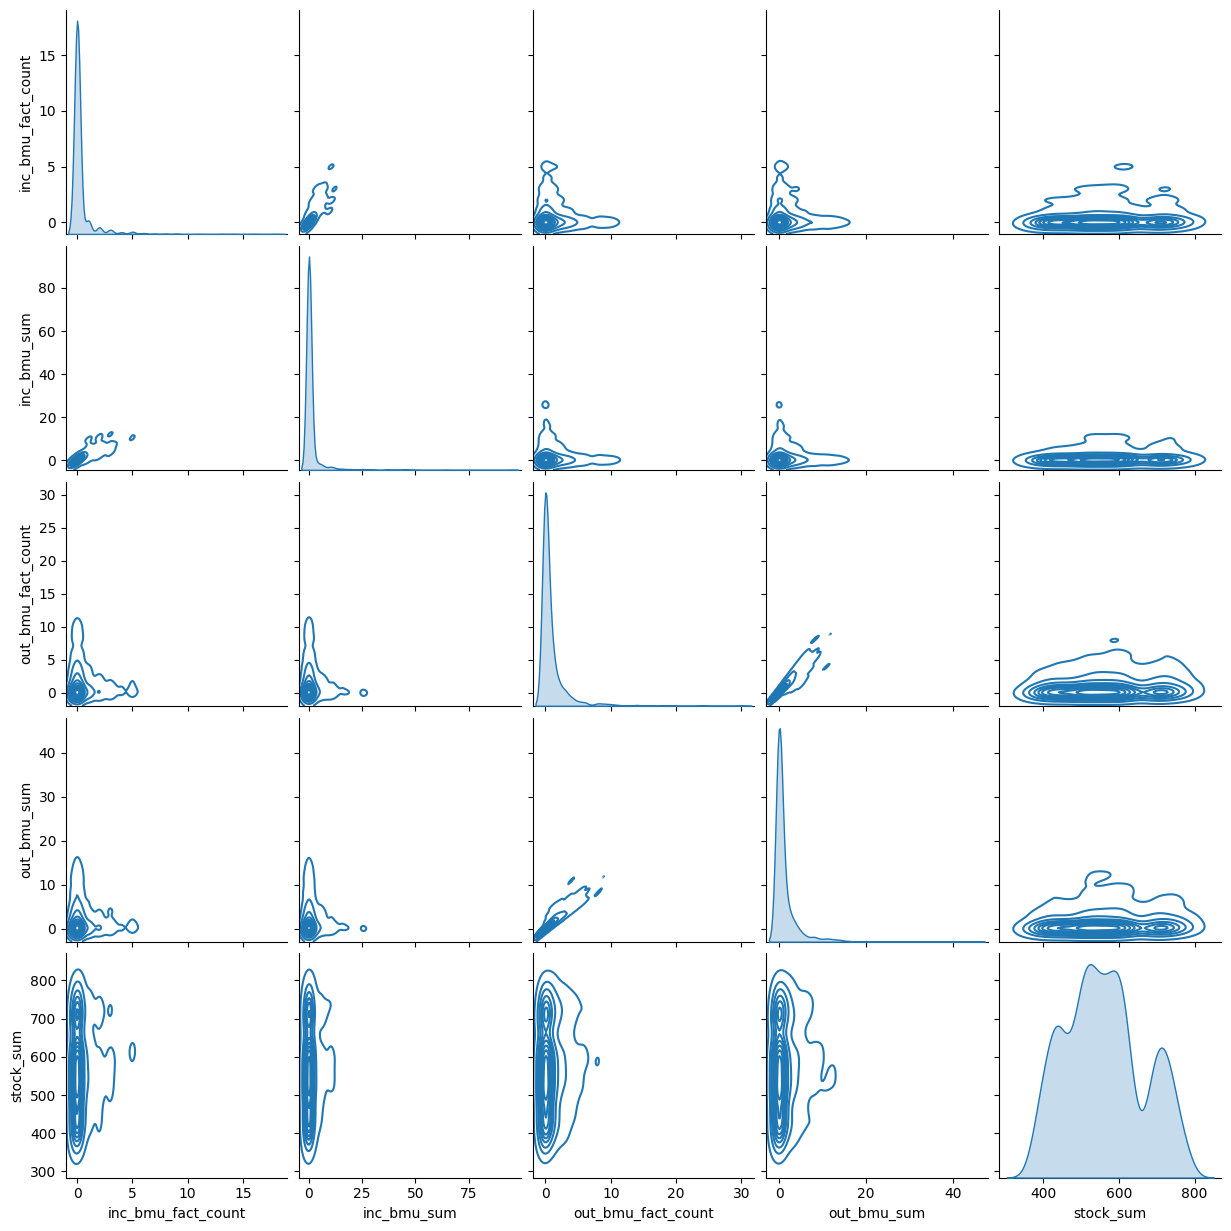

In [14]:
sns.pairplot(df, kind="kde")

Посмторим на корреляцию между признаками

In [15]:
def plot_correlation(data_to_visualize: pd.Series) -> None:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        corr = data_to_visualize.corr()
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111) 
        cax = ax.matshow(corr, cmap = 'coolwarm', vmin = -1, vmax = 1) 
        fig.colorbar(cax ) 
        ticks = np.arange(0, len (data_to_visualize.columns), 1) 
        ax.set_xticks(ticks) 
        plt.xticks() 
        ax.set_yticks (ticks) 
        ax.set_xticklabels(data_to_visualize.columns) 
        ax.set_yticklabels( data_to_visualize.columns)
        plt.savefig(r"heatmap.png", bbox_inches = "tight")
        plt.show()

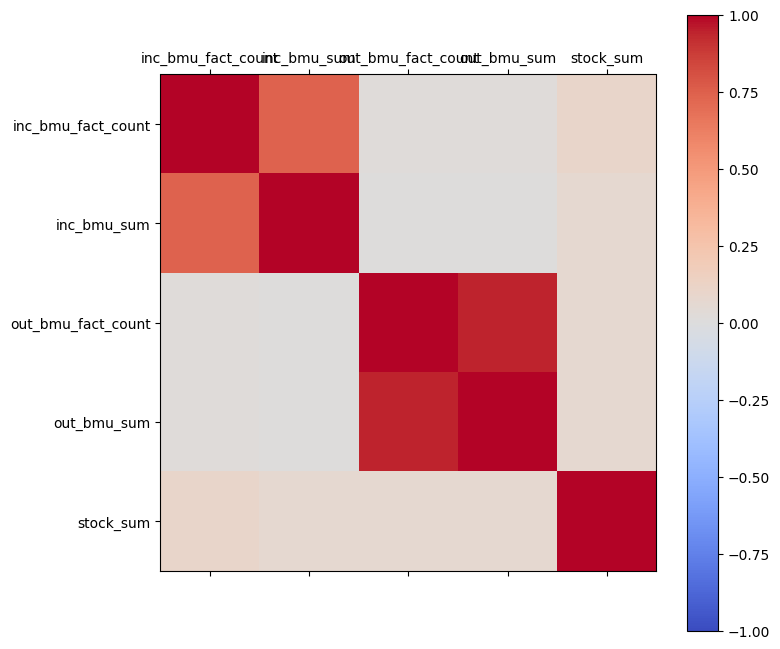

In [16]:
plot_correlation(df)

Проверим информативность признаков с точки зрения дисперсии

In [17]:
scaler = StandardScaler()
pca = PCA()
pipe = Pipeline([("scaler", scaler), ("pca", pca)])
X = pipe.fit_transform(df)

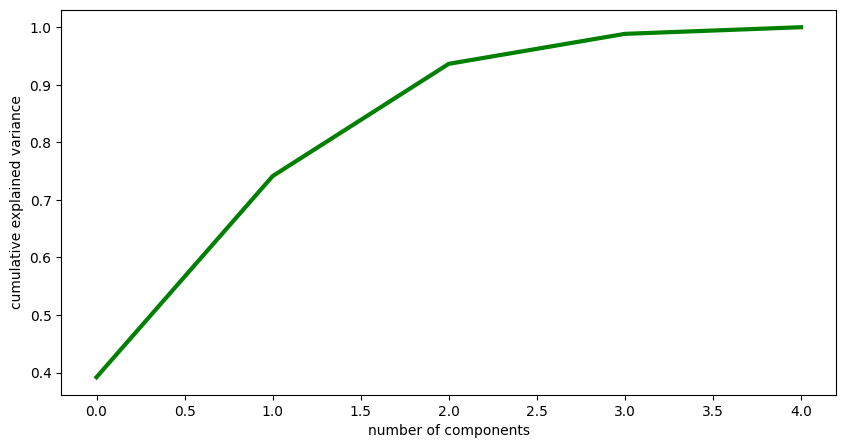

In [18]:
plt.figure(figsize = (10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), c = "g", linewidth = 3)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

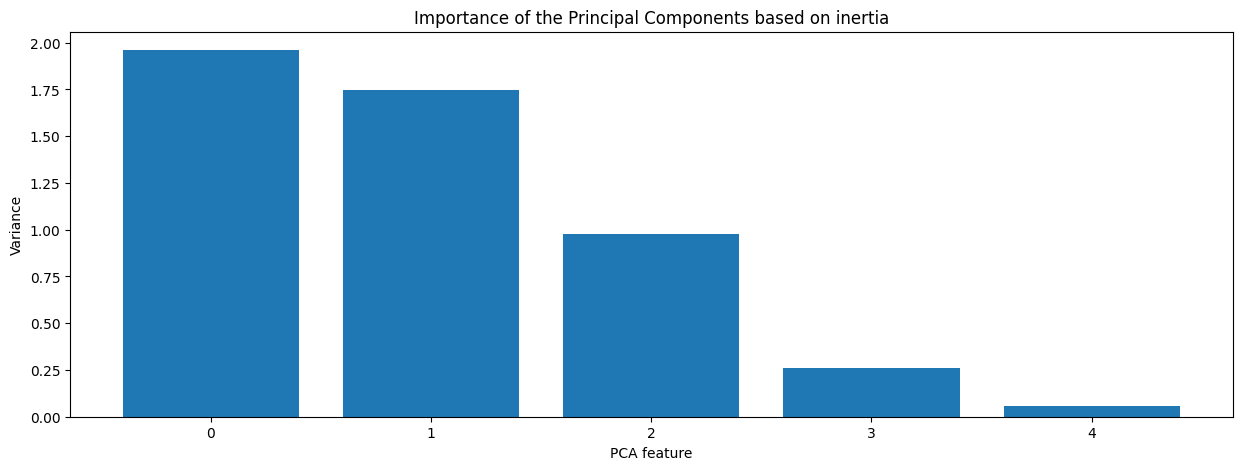

In [19]:
features = range(pca.n_components_)
plt.figure(figsize=(15, 5))
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.title("Importance of the Principal Components based on inertia")
plt.show()

In [20]:
colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

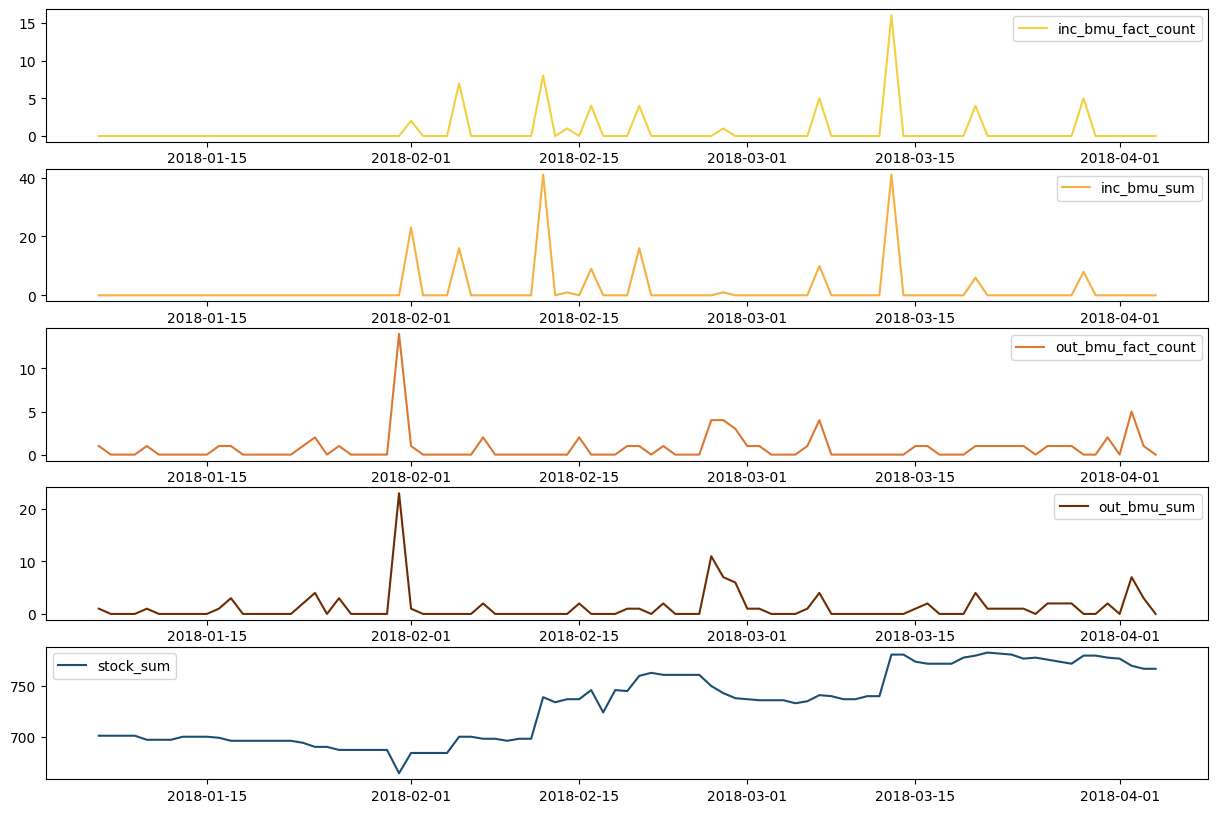

In [21]:
fig, axs = plt.subplots(5, 1, figsize=(15, 10))

for i, column in enumerate(df.columns):
    axs[i].plot(df.loc[(df.index > '2018-01-05') & (df.index < '2018-04-05')][column] , label=column, c=colors[i])
    axs[i].legend()

График ниже показывает, что ряды более менее стационарны, но для полной картины, стоит проверить критерий Дики-Фуллера

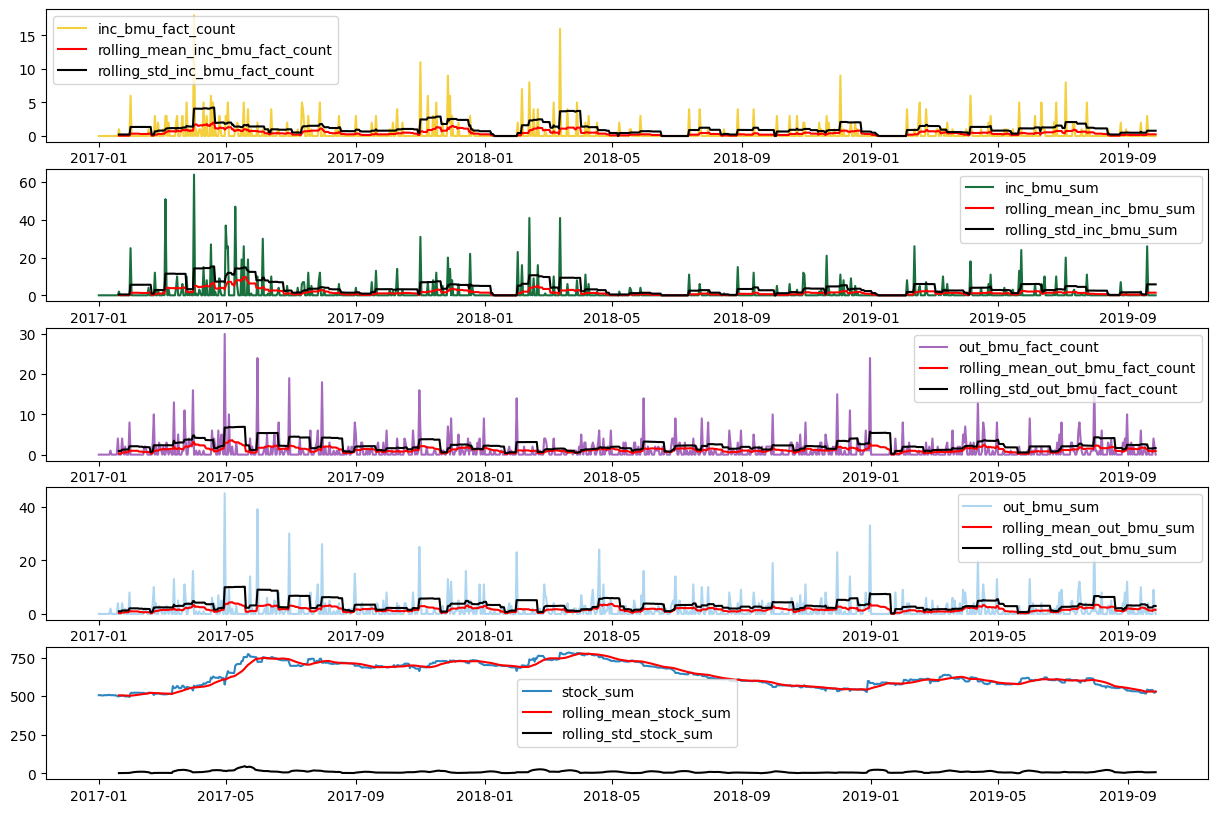

In [22]:
fig, axs = plt.subplots(5, 1, figsize=(15, 10))

for i, column in enumerate(df.columns):
    axs[i].plot(df[column].iloc[:1000], label=column, c=colors[-i])
    axs[i].plot(df[column].rolling(20).mean().iloc[:1000], label="rolling_mean_" + column, c="red")
    axs[i].plot(df[column].rolling(20).std().iloc[:1000], label="rolling_std_" + column, c="black")
    axs[i].legend()

In [23]:
from statsmodels.tsa.stattools import adfuller

for column in df.columns:
    result = adfuller(df[column])
    print(f"P-value of Dickey-fuller test for column {column}: {result[1]}")

P-value of Dickey-fuller test for column inc_bmu_fact_count: 3.0497944669286367e-13
P-value of Dickey-fuller test for column inc_bmu_sum: 0.0
P-value of Dickey-fuller test for column out_bmu_fact_count: 3.555822391631031e-28
P-value of Dickey-fuller test for column out_bmu_sum: 1.4580226331671446e-28
P-value of Dickey-fuller test for column stock_sum: 0.648426741328066


В итоге все колонки стационарны, кроме "stock_sum". Проверим первую прозводную этого признака и увидем, что он стационарен. Его же мы в дальнейшем добавим как один из новых признаков

In [24]:
result = adfuller((df["stock_sum"] - df["stock_sum"].shift(1)).dropna())
print(f"P-value of Dickey-fuller test for first difference of stock_sum: {result[1]}")

P-value of Dickey-fuller test for first difference of stock_sum: 5.4733758128865966e-18


## Детекция аномалий

### Isolation Forest

Попробуем для начала искать аномалии для каждого признака по отдельности, а в конце оставим только те, которые общие для всех

In [25]:
rs = np.random.RandomState(5)

anomalies = dict.fromkeys(df.columns)
for column in df.columns:    
    column_df = pd.DataFrame(df[column])
    forest = IsolationForest(random_state=rs) 
    forest.fit(column_df)
    
    if_scores = pd.Series(forest.decision_function(column_df))
    if_anomalies = forest.predict(column_df)
    if_anomalies = pd.Series(if_anomalies, index=column_df.index).replace([-1,1],[1,0])
    if_anomalies = if_anomalies[if_anomalies==1]
    idx_if_outlier = list(if_anomalies.index)
    anomalies[column] = set(idx_if_outlier)

In [26]:
anomalies.keys()

dict_keys(['inc_bmu_fact_count', 'inc_bmu_sum', 'out_bmu_fact_count', 'out_bmu_sum', 'stock_sum'])

In [27]:
result = anomalies[list(anomalies.keys())[0]]
for column in list(anomalies.keys())[1:]:
    result = result.intersection(anomalies[column])
result

{Timestamp('2017-04-19 00:00:00'),
 Timestamp('2017-04-26 00:00:00'),
 Timestamp('2017-05-11 00:00:00'),
 Timestamp('2017-05-31 00:00:00'),
 Timestamp('2017-06-13 00:00:00'),
 Timestamp('2017-06-19 00:00:00'),
 Timestamp('2017-06-20 00:00:00'),
 Timestamp('2017-09-01 00:00:00'),
 Timestamp('2017-09-16 00:00:00'),
 Timestamp('2017-10-10 00:00:00'),
 Timestamp('2017-11-01 00:00:00'),
 Timestamp('2017-11-27 00:00:00'),
 Timestamp('2017-11-28 00:00:00'),
 Timestamp('2017-12-07 00:00:00'),
 Timestamp('2017-12-18 00:00:00'),
 Timestamp('2017-12-20 00:00:00'),
 Timestamp('2018-02-27 00:00:00'),
 Timestamp('2018-03-07 00:00:00'),
 Timestamp('2018-04-06 00:00:00'),
 Timestamp('2019-03-14 00:00:00'),
 Timestamp('2019-12-26 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-04-24 00:00:00'),
 Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-09-08 00:00:00')}

Попробуем визуализировать эти аномалии

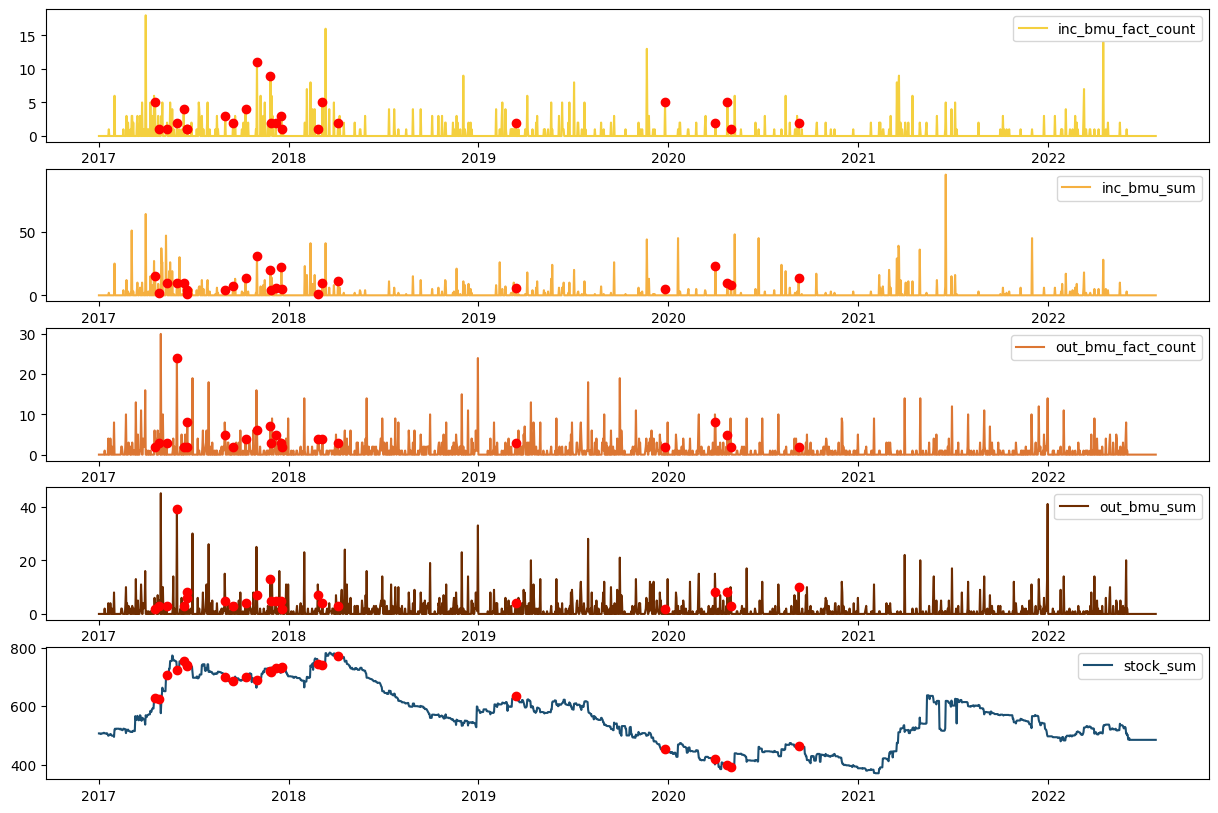

In [28]:
fig, axs = plt.subplots(5, 1, figsize=(15, 10))

for i, column in enumerate(df.columns):
    axs[i].plot(df[column] , label=column, c=colors[i])
    axs[i].plot(df.loc[list(result)][column], "o", c="red")
    axs[i].legend()

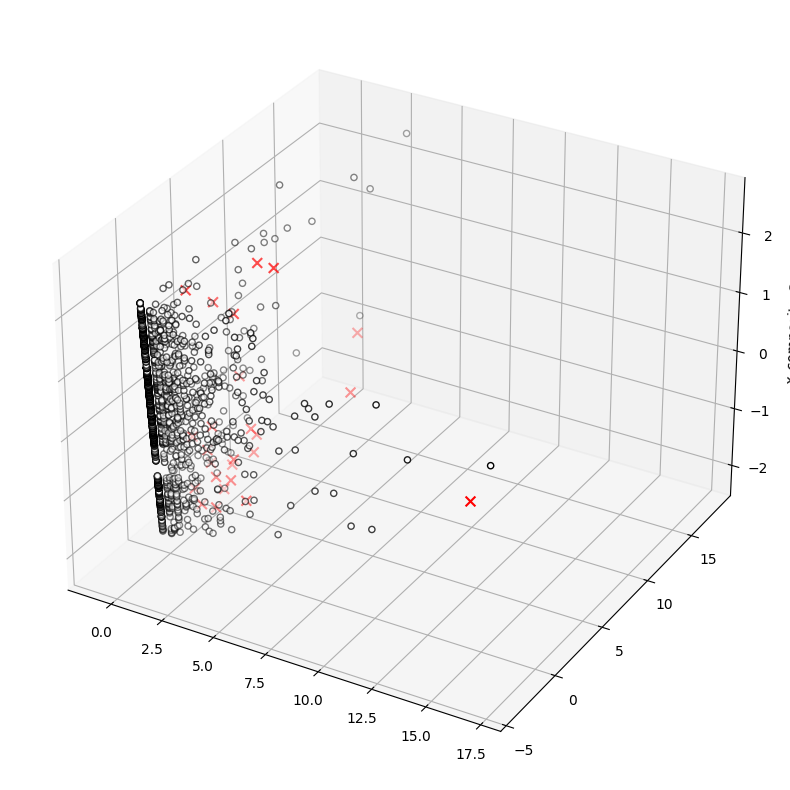

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")


scaler = StandardScaler()
pca = PCA(3)
pipe = Pipeline([("scaler", scaler), ("pca", pca)])
X =  pipe.fit_transform(df)
X = pd.DataFrame(X, index=df.index)

outlier_index = list(result)
ax.scatter(X.loc[~X.index.isin(outlier_index), 0],
           X.loc[~X.index.isin(outlier_index), 1],
           X.loc[~X.index.isin(outlier_index), 2],
           c='white', s=20, edgecolor='k')
ax.scatter(X.loc[X.index.isin(outlier_index), 0],
            X.loc[X.index.isin(outlier_index), 1],
            X.loc[X.index.isin(outlier_index), 2],
            c='red', s=50, marker="x")
plt.show()

Точки, которые алгоритм считает аномалиями, на графиках выглядят вполне нормальными, поэтому попробуем тепереь расмотреть весь датасет за один проход

In [30]:
rs = np.random.RandomState(5)
forest = IsolationForest(random_state=rs) 
forest.fit(df)

if_scores = pd.Series(forest.decision_function(df))
if_anomalies = forest.predict(df)
if_anomalies = pd.Series(if_anomalies, index=df.index).replace([-1,1],[1,0])
if_anomalies = if_anomalies[if_anomalies==1]
idx_if_outlier = list(if_anomalies.index)
if_anomalies

posting_date
2017-01-30    1
2017-01-31    1
2017-02-22    1
2017-02-23    1
2017-03-03    1
             ..
2022-04-17    1
2022-04-22    1
2022-04-30    1
2022-05-19    1
2022-05-31    1
Length: 284, dtype: int64

In [31]:
if_anomalies = if_anomalies.index
if_anomalies = pd.Series(if_anomalies)

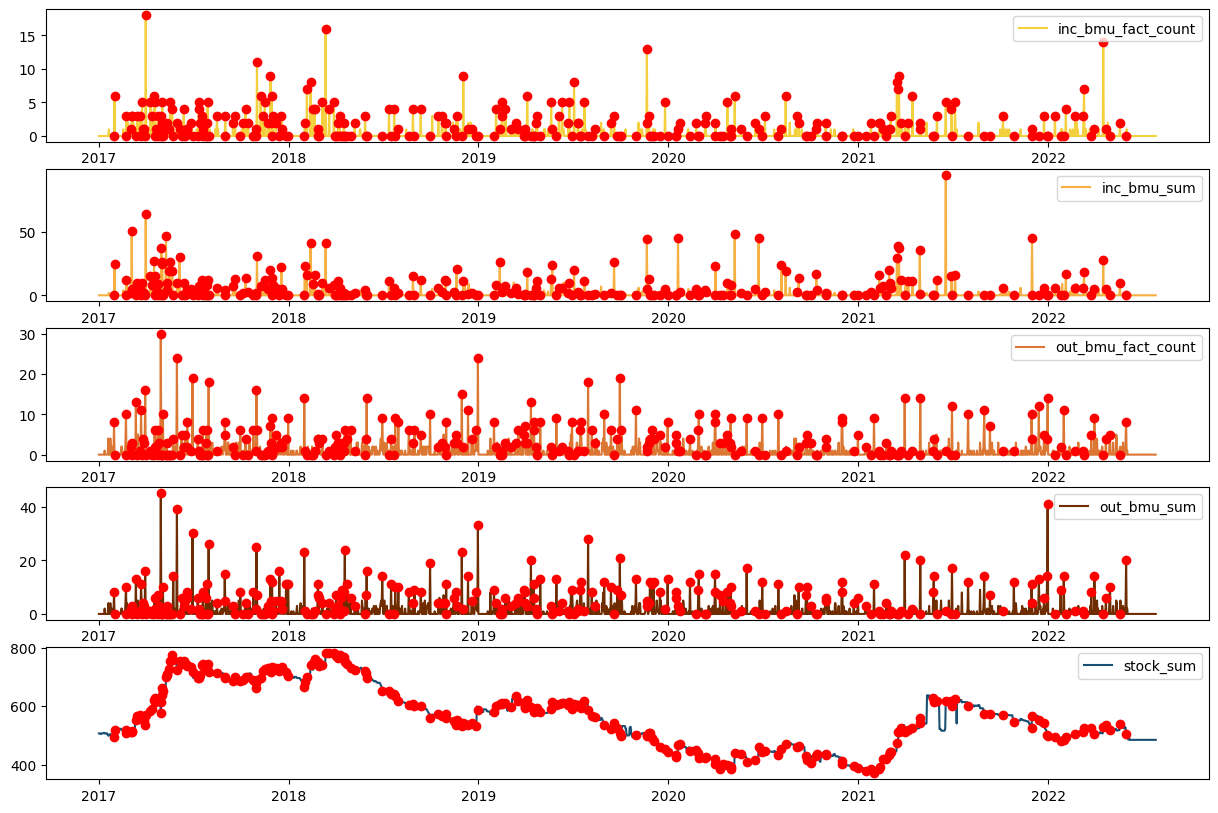

In [32]:
fig, axs = plt.subplots(5, 1, figsize=(15, 10))

for i, column in enumerate(df.columns):
    axs[i].plot(df[column] , label=column, c=colors[i])
    axs[i].plot(df.loc[if_anomalies][column], "o", c="red")
    axs[i].legend()

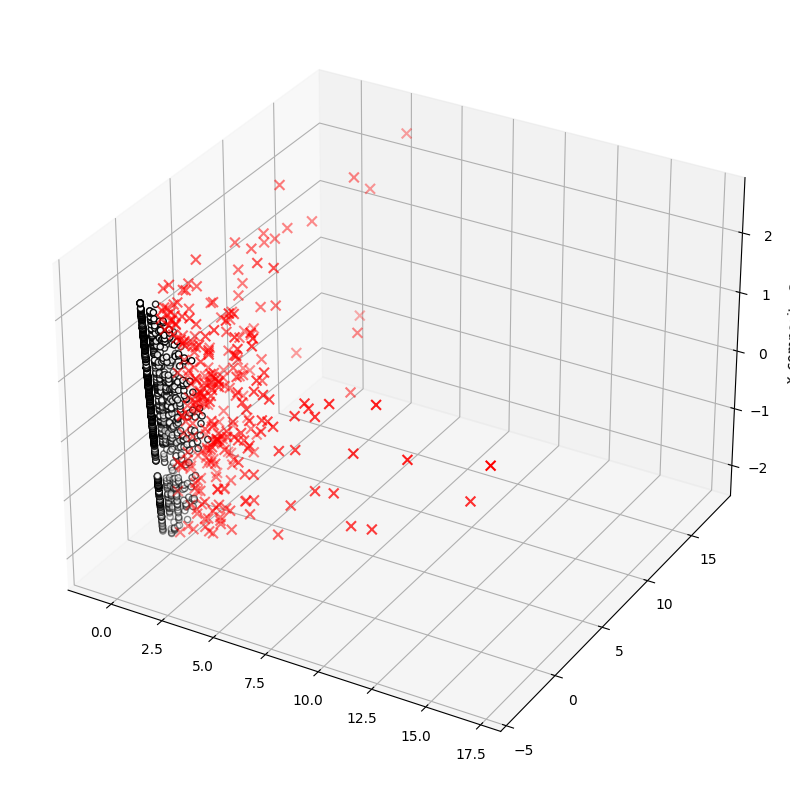

In [33]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")


scaler = StandardScaler()
pca = PCA(3)
pipe = Pipeline([("scaler", scaler), ("pca", pca)])
X =  pipe.fit_transform(df)
X = pd.DataFrame(X, index=df.index)

outlier_index = list(if_anomalies)
ax.scatter(X.loc[~X.index.isin(outlier_index), 0],
           X.loc[~X.index.isin(outlier_index), 1],
           X.loc[~X.index.isin(outlier_index), 2],
           c='white', s=20, edgecolor='k')
ax.scatter(X.loc[X.index.isin(outlier_index), 0],
            X.loc[X.index.isin(outlier_index), 1],
            X.loc[X.index.isin(outlier_index), 2],
            c='red', s=50, marker="x")
plt.show()

А в таком виде, как будто алгоритм изолирующего лесв определил слишком много выбросов. Попробуем ещё две подходы, а имеено:
1. Local Outlier Factor
2. Обычные boxplot-ы

### Local Oulier Factor

In [34]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=1)
lof_predict = lof.fit_predict(df)
lof_predict = pd.Series(lof_predict, index=df.index).replace([-1,1],[1,0])
lof_anomalies = lof_predict[lof_predict==1]
idx_lof_outlier = list(lof_anomalies.index)
lof_anomalies

posting_date
2017-01-12    1
2017-01-30    1
2017-02-17    1
2017-03-05    1
2017-03-06    1
             ..
2022-04-17    1
2022-04-26    1
2022-05-01    1
2022-05-26    1
2022-05-30    1
Length: 267, dtype: int64

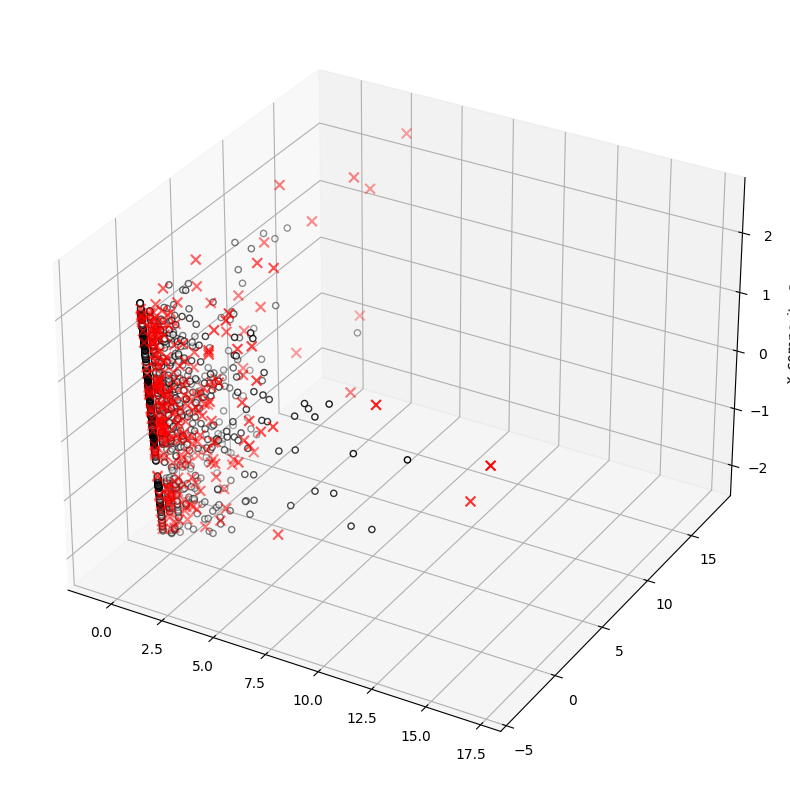

In [35]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")


scaler = StandardScaler()
pca = PCA(3)
pipe = Pipeline([("scaler", scaler), ("pca", pca)])
X =  pipe.fit_transform(df)
X = pd.DataFrame(X, index=df.index)

outlier_index = list(lof_anomalies.index)
ax.scatter(X.loc[~X.index.isin(outlier_index), 0],
           X.loc[~X.index.isin(outlier_index), 1],
           X.loc[~X.index.isin(outlier_index), 2],
           c='white', s=20, edgecolor='k')
ax.scatter(X.loc[X.index.isin(outlier_index), 0],
            X.loc[X.index.isin(outlier_index), 1],
            X.loc[X.index.isin(outlier_index), 2],
            c='red', s=50, marker="x")
plt.show()

### Boxplots

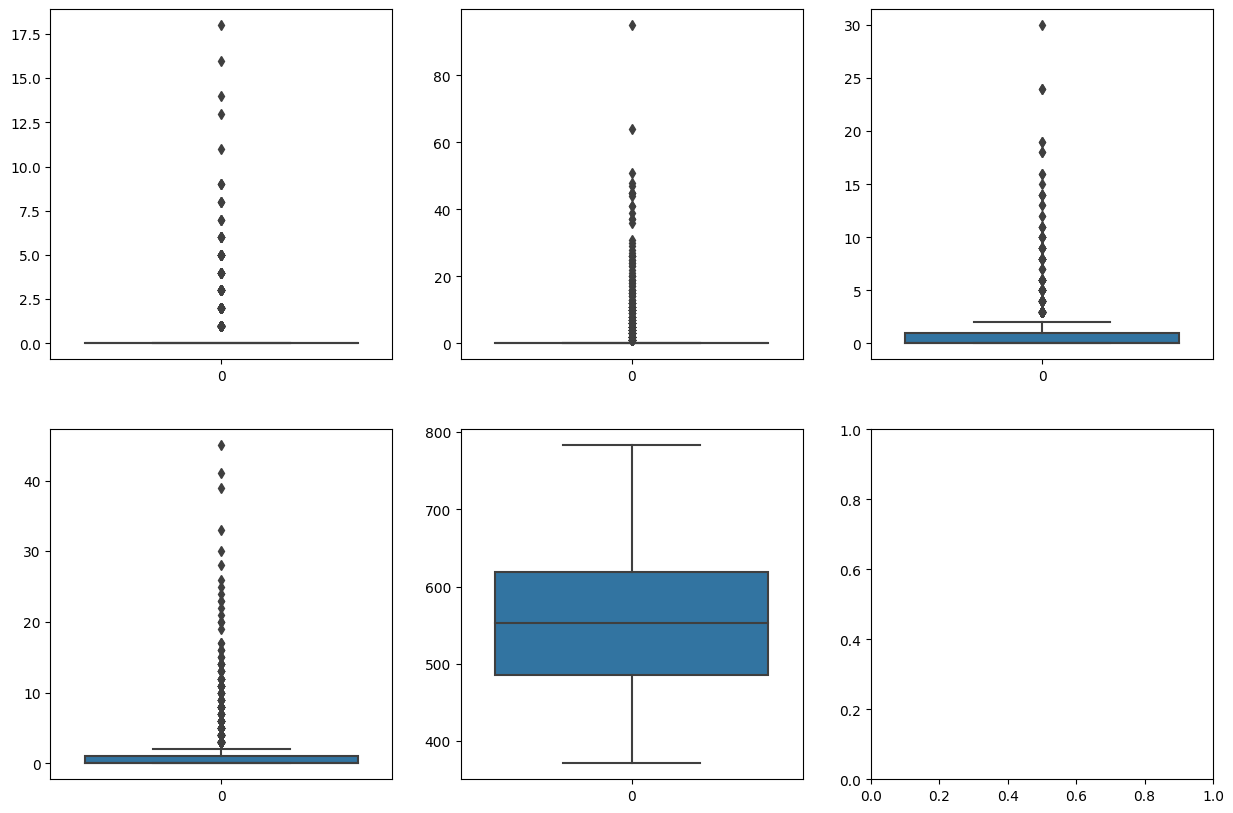

In [36]:
import itertools

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for (i, j), column in zip(itertools.product([0, 1], [0, 1, 2]), df.columns):
    sns.boxplot(df[column], ax=axs[i][j])

In [37]:
df.columns

Index(['inc_bmu_fact_count', 'inc_bmu_sum', 'out_bmu_fact_count',
       'out_bmu_sum', 'stock_sum'],
      dtype='object')

In [38]:
Q1, Q3 = np.percentile(df["inc_bmu_fact_count"] , [25,75])
IQR = Q3 - Q1
ul = Q3 + 1.5 * IQR
ll = Q1 - 1.5 * IQR
outliers = df["inc_bmu_fact_count"][(df["inc_bmu_fact_count"] > ul) | (df["inc_bmu_fact_count"] < ll)]
outliers

posting_date
2017-01-20     1
2017-01-31     6
2017-02-17     1
2017-02-23     3
2017-02-26     2
              ..
2022-04-17    14
2022-04-22     1
2022-04-26     2
2022-05-19     2
2022-06-01     1
Name: inc_bmu_fact_count, Length: 260, dtype: int64

### Детекция аномалий [выводы]

Из всех алгоритмов на мой взгляд самый правдободный local otlier factor, но к сожалению все алгоритмы очень много информативных точек считают выбросами. Это не удивительно, так как данные у нас слишком разряжены, и все подходы в том или ином ввиде пытаются определеть, точки которые сильно выбываются с общего кластера или сильно отличаются по распределению. Кроме того удалять 200+ точек с выборки где 400+ не нулевых точек, не совсем хочеться...
</br>
Поэтому мне кажется для грамотного определения выбросов, стоит более сильно углубляться в подробности самих данных, а пока попробуем обучить модель без удаления выбросов и посмотрим на качество предсказаний.

## Построение новых признаков

Возможныые признаки:

1. Дневное изменение количества товаров склада, ну или иначе говоря первая производная признака "stock_sum"
2. Скользящий товароборот склада (скользящее сумма оличий изменений запасов за месяц, иначе говоря сумма дневных изменений количества товаров склада за месяц)
3. Скользащая сумма закупок за 30 дней. 
4. Скользащее отличие между приходами и списаниями за 30 дней, так как обычно в конце месяца делаются какие-то отчеты и в зависимости анализа этих отчетов, количество закупок или списаний в следующем месяце могут изменяться 
5. Скользящий товароборот в количестве пришедших материалов за месяц
6. Доля приходов по отношению количества товаров на складе.
7. Доля списаний по отношению количества товаров на складе.
8. Временные признаки

Целевая переменная - скользящая сумма суммы списаний(inc_bmu_sum) за будущий месяц

In [39]:
target = df["inc_bmu_sum"].rolling(30).sum().shift(-30)
df.columns

Index(['inc_bmu_fact_count', 'inc_bmu_sum', 'out_bmu_fact_count',
       'out_bmu_sum', 'stock_sum'],
      dtype='object')

In [40]:
# Дневное изменение
df["stock_sum_diff"] = df["stock_sum"] - df["stock_sum"].shift(1)
# товароборот товаров склада за месяц 
df["total_stock_sum_diff"] = df["stock_sum_diff"].rolling(30).sum()

df["monthly_inc_bmu_fact_count"] = df["inc_bmu_fact_count"].rolling(30).sum()
df["monthly_out_bmu_fact_count"] = df["out_bmu_fact_count"].rolling(30).sum()

# скользящий товароборот за месяц
df["monthly_inc_out_count_diff"] = (df["inc_bmu_fact_count"] - df["out_bmu_fact_count"]).rolling(30).sum()
# скользящий товароборот в количестве пришедших материалов за месяц
df["monthly_inc_out_sum_diff"] = (df["inc_bmu_sum"] - df["out_bmu_sum"]).rolling(30).sum()

# доля приходов 
df["share_of_inc"] = df["inc_bmu_fact_count"] / df["stock_sum"]
# доля списаний
df["share_of_out"] = df["out_bmu_fact_count"] / df["stock_sum"]

In [41]:
nan_index = df[df.isna().any(axis=1)].index
target.drop(nan_index)
df = df.drop(nan_index)

In [42]:
target.isna().sum()

30

Ну, и добавим временные признаки

In [43]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek.astype("category")
    df['month'] = df.index.month.astype("category")
    df['year'] = df.index.year.astype("category")
    df['dayofyear'] = df.index.dayofyear.astype("category")
    df['dayofmonth'] = df.index.day.astype("category")
    df['weekofyear'] = df.index.isocalendar().week.astype("category")
    return df

In [44]:
df = create_features(df)
df

,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,stock_sum,stock_sum_diff,total_stock_sum_diff,monthly_inc_bmu_fact_count,monthly_out_bmu_fact_count,monthly_inc_out_count_diff,monthly_inc_out_sum_diff,share_of_inc,share_of_out,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
posting_date,,,,,,,,,,,,,,,,,,,
2017-01-31,6,25.0,0,0.0,520.0,25.0,13.0,7.0,20.0,-13.0,6.0,0.011538,0.0,1,1,2017,31,31,5
2017-02-01,0,0.0,0,0.0,523.0,3.0,16.0,7.0,20.0,-13.0,6.0,0.000000,0.0,2,2,2017,32,1,5
2017-02-02,0,0.0,0,0.0,521.0,-2.0,14.0,7.0,20.0,-13.0,6.0,0.000000,0.0,3,2,2017,33,2,5
2017-02-03,0,0.0,0,0.0,523.0,2.0,18.0,7.0,20.0,-13.0,6.0,0.000000,0.0,4,2,2017,34,3,5
2017-02-04,0,0.0,0,0.0,523.0,0.0,18.0,7.0,20.0,-13.0,6.0,0.000000,0.0,5,2,2017,35,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-23,0,0.0,0,0.0,485.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,5,7,2022,204,23,29
2022-07-24,0,0.0,0,0.0,485.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,6,7,2022,205,24,29
2022-07-25,0,0.0,0,0.0,485.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0,7,2022,206,25,30


## Подбор модели и обучение

In [45]:
X_train = df.values
y_train = target[:2004].values

print(X_train.shape)
print(y_train.shape)

(2004, 19)
(2004,)


In [102]:
def train_model(model: Union[xgb.XGBRegressor, RegressorMixin],
                X_train: np.ndarray, y_train: np.ndarray) -> Tuple[dict, dict]:
    train_scores = {"rmse": [], "r^2": []}
    val_scores = {"rmse": [], "r^2": [], "adjacent": []}
    
    tskf = TimeSeriesSplit(n_splits=10)
    
    for train_index, val_index in tqdm(tskf.split(X_train, y_train)):
        # Training    
        model.fit(X_train[train_index], y_train[train_index], 
                  verbose=0,
                  eval_set=[(X_train[train_index], y_train[train_index]),(X_train[val_index], y_train[val_index])]
                 )
        
        train_preds = model.predict(X_train[train_index])
        
        try:
            curr_train_mse_score = mean_squared_error(y_train[train_index], train_preds, squared=False)
        except:
            curr_train_mse_score = np.inf
        
        try:
            curr_train_r2_score = r2_score(y_train[train_index], train_preds)
        except:
            curr_train_r2_score = 0
        
        train_scores["rmse"].append(curr_train_mse_score)
        train_scores["r^2"].append(curr_train_r2_score)
        
        # Validation
        val_preds = model.predict(X_train[val_index])
        
        try:
            curr_val_mse_score = mean_squared_error(y_train[val_index], val_preds, squared=False)
        except:
            curr_val_mse_score = np.inf
        
        try:
            curr_val_r2_score = r2_score(y_train[val_index], val_preds)
        except:
            curr_val_r2_score = 0
                
        val_scores["rmse"].append(curr_val_mse_score)
        val_scores["r^2"].append(curr_val_r2_score)
        
        print("rmse:{:.3f} | r2:{:.3f}".format(
            curr_val_mse_score,
            curr_val_r2_score))
        
    return train_scores,  val_scores

In [103]:
%%time
baseline = xgb.XGBRegressor(n_jobs=-1, tree_method="gpu_hist",
                            enable_categorical=True, verbosity=1)

baseline_train_scores = []
baseline_val_scores = []

baseline_train_scores, baseline_val_scores = train_model(baseline, X_train, y_train)

0it [00:00, ?it/s]

rmse:12.801 | r2:0.732
rmse:13.787 | r2:0.830
rmse:7.661 | r2:0.766
rmse:7.609 | r2:0.664
rmse:12.155 | r2:0.720
rmse:8.946 | r2:0.832
rmse:6.620 | r2:0.822
rmse:13.120 | r2:0.929
rmse:6.502 | r2:0.838
rmse:8.785 | r2:0.716
CPU times: user 3.18 s, sys: 33.1 ms, total: 3.21 s
Wall time: 2.81 s


In [104]:
val_score = sum(baseline_val_scores["r^2"]) / len(baseline_val_scores["r^2"]) 
print(f"Average validation r^2 score: {val_score}")

Average validation r^2 score: 0.7847863477678548


In [52]:
def draw_learning_curves(model: Union[xgb.XGBRegressor, RegressorMixin]):
    results = model.evals_result()
    epochs = len(results['validation_0'])
    x_axis = range(0, epochs)
    
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(list(results['validation_0']["rmse"]), label='Train')
    ax.plot(list(results['validation_1']["rmse"]), label='Test')
    ax.legend()
    plt.ylabel('rmse')
    plt.title('GridSearchCV XGBoost mlogloss')
    plt.show()

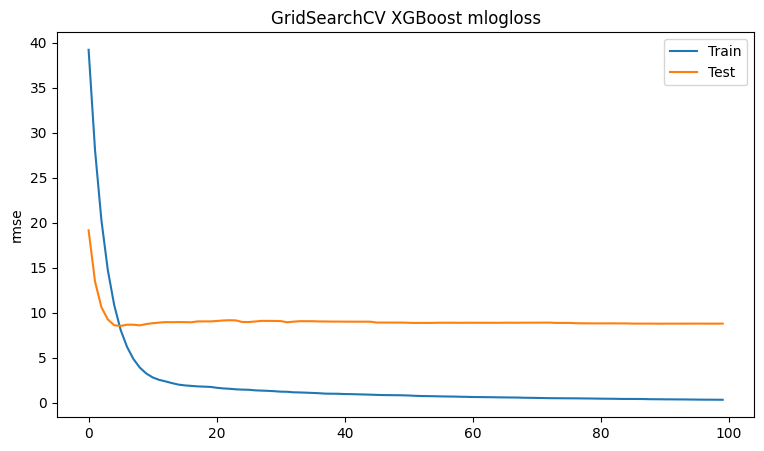

In [53]:
draw_learning_curves(baseline)

In [54]:
def draw_feature_importance(model: Union[xgb.XGBRegressor, RegressorMixin],
                            feature_names):

    # feat importance with names f1,f2,...
    axsub = xgb.plot_importance(model)

    # get the original names back
    Text_yticklabels = list(axsub.get_yticklabels())
    dict_features = dict(enumerate(feature_names))
    lst_yticklabels = [ Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
    lst_yticklabels = [ dict_features[int(i)] for i in lst_yticklabels]

    axsub.set_yticklabels(lst_yticklabels)
    print(dict_features)
    plt.show()

{0: 'inc_bmu_fact_count', 1: 'inc_bmu_sum', 2: 'out_bmu_fact_count', 3: 'out_bmu_sum', 4: 'stock_sum', 5: 'stock_sum_diff', 6: 'total_stock_sum_diff', 7: 'monthly_inc_bmu_fact_count', 8: 'monthly_out_bmu_fact_count', 9: 'monthly_inc_out_count_diff', 10: 'monthly_inc_out_sum_diff', 11: 'share_of_inc', 12: 'share_of_out', 13: 'dayofweek', 14: 'month', 15: 'year', 16: 'dayofyear', 17: 'dayofmonth', 18: 'weekofyear'}


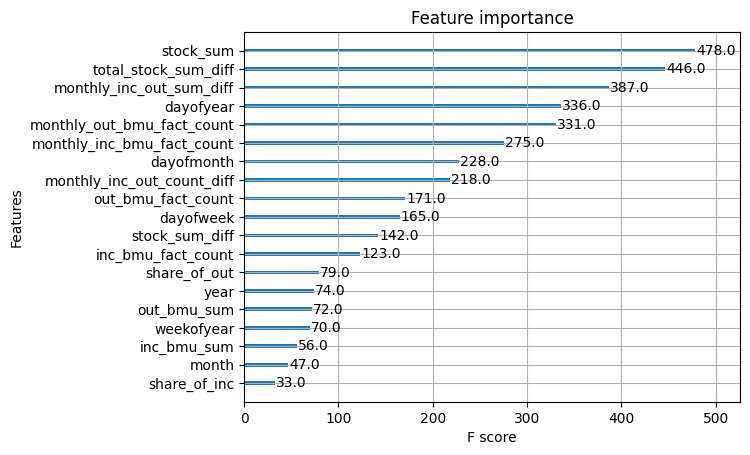

In [55]:
draw_feature_importance(baseline, df.columns)

In [59]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 38.0 MB/s eta 0:00:00


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


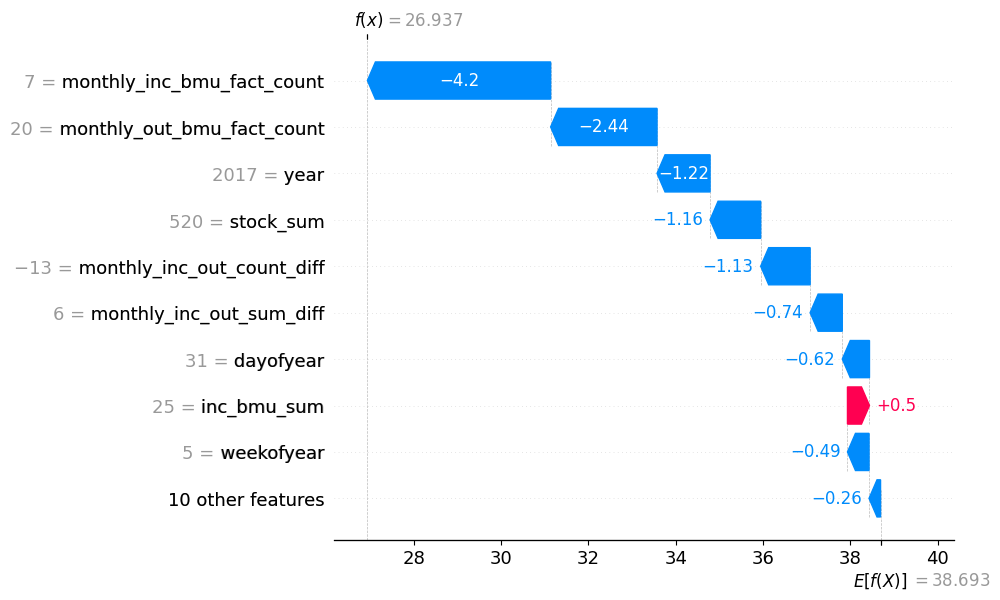

In [71]:
import shap

explainer = shap.Explainer(baseline)
shap_values = explainer(df)

# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

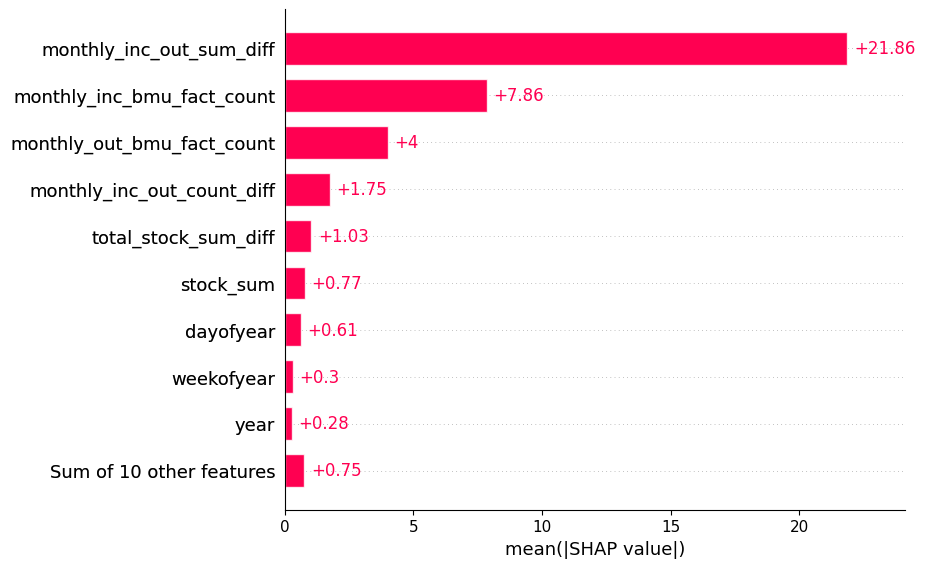

In [72]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


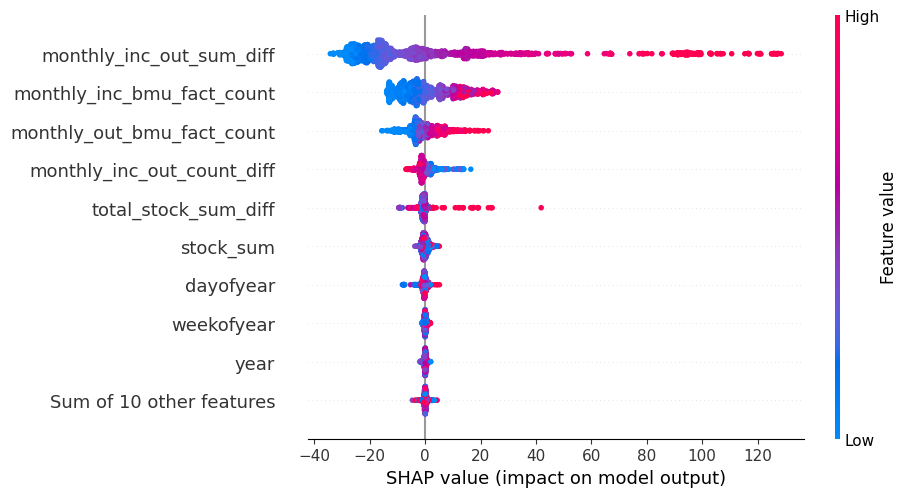

In [73]:
shap.plots.beeswarm(shap_values)

In [58]:
df["monthly_inc_out_sum_diff"].describe()

count    2004.000000
mean       -4.370758
std        38.952674
min       -94.000000
25%       -29.000000
50%       -12.000000
75%        14.000000
max       177.000000
Name: monthly_inc_out_sum_diff, dtype: float64

In [60]:
df["monthly_inc_bmu_fact_count"].describe()

count    2004.000000
mean       10.159182
std         9.110467
min         0.000000
25%         4.000000
50%         7.000000
75%        14.000000
max        50.000000
Name: monthly_inc_bmu_fact_count, dtype: float64

Видно, что признаки, которые мы добавили имеют основное влияние на итоговый результат предсказаний. Кроме того если сравнить информативность признаков по критерию информативность XGBoost(среднее количество разделений) и по SHAP значениям, то видно что топ основных признаков плюс минус один и тот же. 
</br>
Отдельнее расмотрение признаков тоже достаточно понятный. Например признак "monthly_inc_bmu_fact_count" имеет толстый хвост слева на графике Bee Swarm - это из-за того, что данные у нас слишком разряжены и во многих 30 дневных периодах у нас банально не было не нулевых признаков, что ещё раз можно доказать посмотрев на распределение значений признака.

### Подбор параметров

Так как данных мало и модель обучается быстро, то вприницпе можем запустить GridSearch для подбора параметров. Но в конце нотбука, можете прочитать как бы я сделал кроссвалидацию и подбор парамтеров лучше было бы у меня больше времени.

In [105]:
parameters = {
    'max_depth': [3, 6, 9, 12],
    'n_estimators': range(70, 130, 15),
    'max_leaves': [0, 1, 5, 7, 13],
    'learning_rate': [0.3, 0.1, 0.01]
}

In [106]:
estimator = xgb.XGBRegressor(n_jobs=-1, tree_method="gpu_hist",
                             enable_categorical=True, verbosity=3)

tskf = TimeSeriesSplit(n_splits=10)

In [107]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = "r2",
    n_jobs = -1,
    cv = tskf,
    verbose=3
)

In [109]:
%%time
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[09:10:37] ======== Monitor (0): HostSketchContainer ========
[09:10:37] AllReduce: 0.01059s, 1 calls @ 10590us

[09:10:37] MakeCuts: 0.019213s, 1 calls @ 19213us

[09:10:37] DEBUG: ../src/tree/updater_gpu_hist.cu:755: [GPU Hist]: Configure
[09:10:37] ======== Monitor (0):  ========
[09:10:37] InitCompressedData: 4.6e-05s, 1 calls @ 46us

[09:10:37] ======== Monitor (0): Learner ========
[09:10:37] Configure: 0.006648s, 1 calls @ 6648us

[09:10:37] EvalOneIter: 0.000779s, 115 calls @ 779us

[09:10:37] GetGradient: 0.005051s, 115 calls @ 5051us

[09:10:37] PredictRaw: 0.00024s, 115 calls @ 240us

[09:10:37] UpdateOneIter: 0.135059s, 115 calls @ 135059us

[09:10:37] ======== Monitor (0): GBTree ========
[09:10:37] BoostNewTrees: 0.120946s, 115 calls @ 120946us

[09:10:37] CommitModel: 4.7e-05s, 115 calls @ 47us

[09:10:37] ======== Device 0 Memory Allocations:  ========
[09:10:37] Peak memory usage: 32MiB
[09:10:37] Number 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, imp...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.3, 0.1, 0.01],
                         'max_depth': [3, 6, 9, 12],
                         'max_leaves': [0, 1, 5, 7, 13],
                         'n_estimators': range(70, 130, 15)},
             scoring='r2', verbose=3)

In [110]:
print(grid_search.best_score_)

0.8291345421648497


In [111]:
print(grid_search.best_params_)

{'learning_rate': 0.3, 'max_depth': 6, 'max_leaves': 7, 'n_estimators': 115}


### Лучшая модель

In [112]:
best_model = xgb.XGBRegressor(n_jobs=-1, tree_method="gpu_hist",
                              learning_rate=0.3, max_depth=6, max_leaves=7,
                              n_estimators = 115, enable_categorical=True,
                              verbosity=1)

best_model_train_scores = []
best_model_val_scores = []

best_model_train_scores, best_model_val_scores = train_model(
    best_model,
     X_train,
     y_train)

0it [00:00, ?it/s]

rmse:12.403 | r2:0.748
rmse:13.119 | r2:0.846
rmse:8.879 | r2:0.686
rmse:6.499 | r2:0.755
rmse:9.774 | r2:0.819
rmse:7.066 | r2:0.895
rmse:4.681 | r2:0.911
rmse:12.196 | r2:0.938
rmse:6.407 | r2:0.843
rmse:6.371 | r2:0.850


In [115]:
best_r2_score = sum(best_model_val_scores["r^2"]) / len(best_model_val_scores["r^2"]) 
best_rmse_score = sum(best_model_val_scores["rmse"]) / len(best_model_val_scores["rmse"]) 
print(f"Average validation r^2 score: {best_r2_score}")
print(f"Average validation RMSE score: {best_rmse_score}")

Average validation r^2 score: 0.8291345421648499
Average validation RMSE score: 8.739588501122116


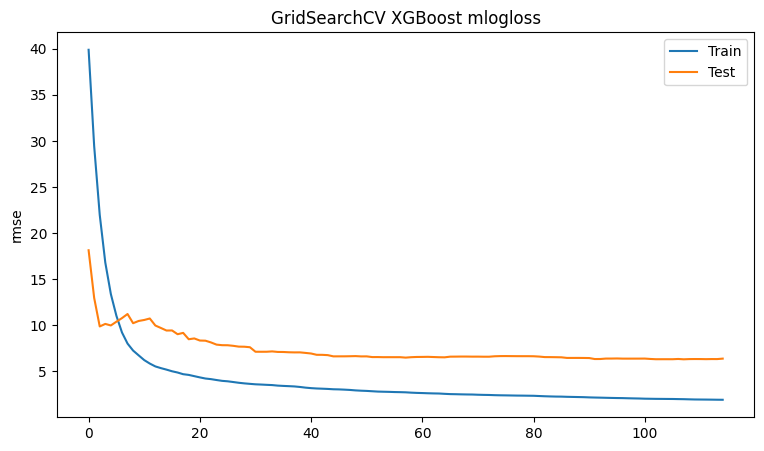

In [123]:
draw_learning_curves(best_model)

{0: 'inc_bmu_fact_count', 1: 'inc_bmu_sum', 2: 'out_bmu_fact_count', 3: 'out_bmu_sum', 4: 'stock_sum', 5: 'stock_sum_diff', 6: 'total_stock_sum_diff', 7: 'monthly_inc_bmu_fact_count', 8: 'monthly_out_bmu_fact_count', 9: 'monthly_inc_out_count_diff', 10: 'monthly_inc_out_sum_diff', 11: 'share_of_inc', 12: 'share_of_out', 13: 'dayofweek', 14: 'month', 15: 'year', 16: 'dayofyear', 17: 'dayofmonth', 18: 'weekofyear'}


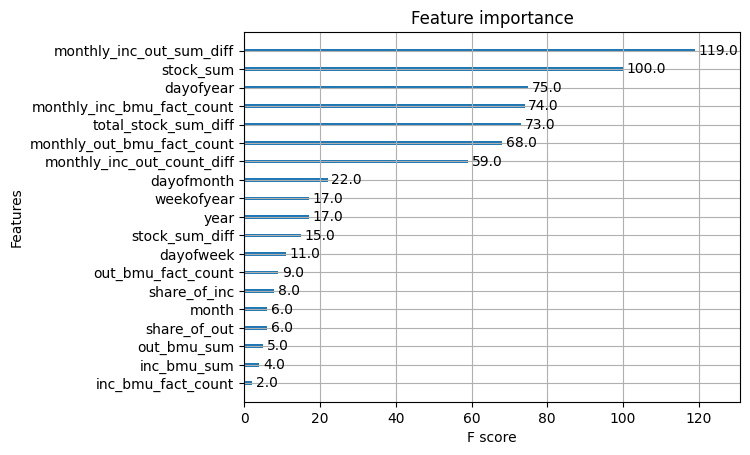

In [117]:
draw_feature_importance(best_model, df.columns)

In [119]:
import shap

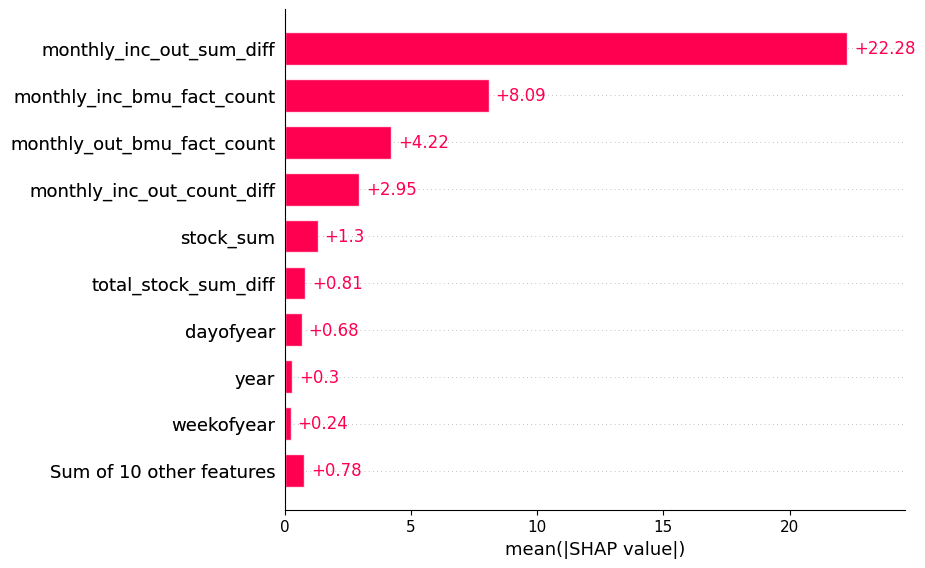

In [121]:
best_explainer = shap.Explainer(best_model)
best_shap_values = best_explainer(df)
shap.plots.bar(best_shap_values)

**Видим, что результаты о важности признаов SHAP-а и XGBoost стали ещё ближе, что не может не радовать)**  

<Axes: >

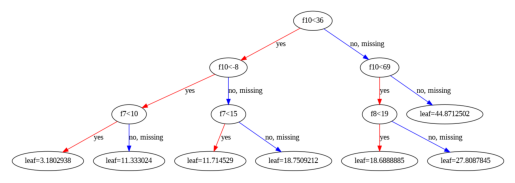

In [146]:
xgb.plot_tree(best_model)

## Бонус

Давайте посмотрим какие результаты получили бы, если просто запустили бы XGBoost без  feature engineering-а.

In [141]:
df_copy = pd.read_parquet(r"Копия zra_4_150_40_ts.parquet")

In [142]:
df_copy = df_copy.set_index("posting_date")
df_copy.index = pd.to_datetime(df_copy.index)
df_copy = df_copy[['inc_bmu_fact_count', 'inc_bmu_sum',
       'out_bmu_fact_count', 'out_bmu_sum', 'stock_sum']]

df_copy = create_features(df_copy)

In [143]:
target_copy = df_copy["inc_bmu_sum"].rolling(30).sum().shift(-30)
dummy_nan_index = target_copy[target_copy.isna()].index
target_copy = target_copy.drop(dummy_nan_index)
df_copy = df_copy.drop(dummy_nan_index)

In [144]:
X_train_copy = df_copy.values
y_train_copy = target_copy.values

In [145]:
dummy_model = xgb.XGBRegressor(n_jobs=-1, tree_method="gpu_hist",
                               enable_categorical=True, verbosity=1)

dummy_train_scores = []
dummy_val_scores = []

dummy_train_scores, dummy_val_scores = train_model(dummy_model,
                                                   X_train_copy,
                                                   y_train_copy);

0it [00:00, ?it/s]

rmse:33.292 | r2:-0.814
rmse:58.334 | r2:-2.038
rmse:15.270 | r2:0.071
rmse:102.017 | r2:-59.433
rmse:26.673 | r2:-0.350
rmse:28.048 | r2:-0.654
rmse:37.968 | r2:-4.844
rmse:67.185 | r2:-0.869
rmse:17.146 | r2:-0.128
rmse:58.554 | r2:-11.640


# Победа!

Этот результат ещё раз доказывает, что мы сделали правильный feature-engineering, ведь без наших сгенерированных признаков модель не смогла понять нужные зависимости.

## Результаты и дальнейшие улучшения

После нашего маленького исследования получили результат на валидации $r^2 = 0.83$ и $\mathit{MSE} = 8.74$. Результат можно было улучшить ещё больше, но к сожалению, из-за ограниченности времени, не успел тестировать все гипотезы и идеи. Какие дальнейшие улучшения можно сделать.

1. [Упрощение модели] - попробовать удалить некоторые признаки, которые не информативы по критериям выше, тем самым упростив модель. Понятно, что принимать значения shap как неоспоримую точку опоры не стоит, но как неплохой бейлайн вполне разумно.
2. [Детекция аномалий] - детекция аномалий очень важная часть, как я уже говорил выше, можно было попробовать сделать более глубокий анализ данных, а так же попробовать уменьшить влияние нулей на работу алгоритма. Либо можно было сделать более грамотную кросс-валидацию, о чем ниже:
3. [Кросс валидация] - time series split кросс-валидация, не очень хороший подход, так как модель каждый раз видит кусок который уже видел. Кроме того с учетом выбросов результаты у нас будут скорее всего не очень правдоподобны, тем более что у нас основной метрикой является $r^2$ score, которая оценивает вариативность модели и очень чувствительна к выбросам, т.е. ожидать хороший стабильный валидационный скор не стоит.</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Поэтому предлагается валидироваться чуть иначе. А именно сделать не 5 фолдов и посмотреть на средний скор, а 10 кросс-валидаций с 5 фолдами и сравнить модели с бейзлайном на одних и тех же фолдах с помощью Т-статистики. Таким образом, если даже в какой-нибудь фолд попадут сильно разбросанные данные или выбросы, то все модели получат плохую оценку на этом фолде, и мы можем сравнить какая из моделей работает лучше.